# SEASONAL MODELS

In [ ]:
# System
# ================================
import os

# Data import and manipulation
# ================================
import pandas as pd
import re

# Modelling and forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


from skforecast.model_selection_statsmodels import backtesting_sarimax
from skforecast.model_selection_statsmodels import grid_search_sarimax
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_absolute_percentage_error

# Plots
# ==============================================================================
import seaborn as sn
from matplotlib import pyplot as plt
import numpy as np


# Warnings config
# ==============================================================================
import warnings

warnings.filterwarnings('ignore')

---
---
## 1 Passaggi preliminari

---
### 1.1 Importazione dati e split degli stessi in training, validation e test set

In [2]:
# Identificazione path della directory del file di lavoro
py_path = re.sub(r"\\", "/", os.environ["PYTHONPATH"])

In [3]:
data = pd.read_csv(py_path + "/Forecasting_Repository/data/processed/processed_data.csv")  #, index_col="time")
# data.index = pd.to_datetime(data.index)
data["time"] = pd.to_datetime(data["time"])
data

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,price actual,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density,Holidays
0,2015-01-01 00:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,65.41,1.000000e-07,0.451,0.0,0.0,0.0,2.781,0.0868,11.948,1
1,2015-01-01 01:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,64.92,2.000000e-07,0.234,0.0,0.0,0.0,2.781,0.1135,11.957,1
2,2015-01-01 02:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,64.48,2.000000e-07,0.129,0.0,0.0,0.0,2.781,0.0127,11.965,1
3,2015-01-01 03:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,59.32,2.000000e-07,0.008,0.0,0.0,0.0,0.278,0.1154,11.971,1
4,2015-01-01 04:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,56.04,1.000000e-07,0.042,0.0,0.0,0.0,0.278,0.0984,11.978,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,77.02,0.000000e+00,6.908,0.0,0.0,0.0,0.000,0.0305,11.669,0
35060,2018-12-31 20:00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,76.16,0.000000e+00,6.164,0.0,0.0,0.0,0.000,0.0338,11.692,0
35061,2018-12-31 21:00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,74.30,0.000000e+00,5.575,0.0,0.0,0.0,0.000,0.0408,1.171,0
35062,2018-12-31 22:00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,69.89,0.000000e+00,5.146,0.0,0.0,0.0,0.000,0.0446,11.724,0


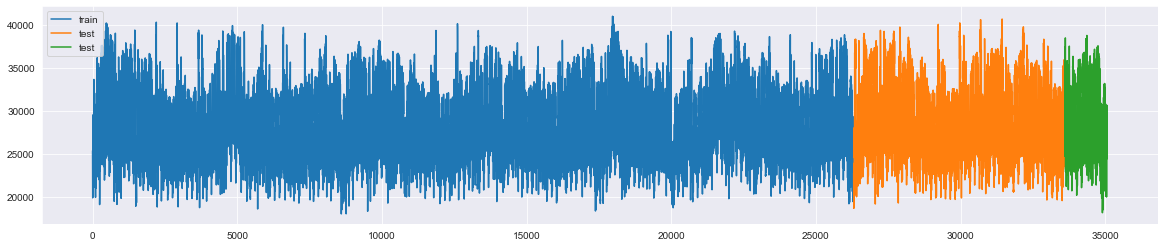

In [4]:
# Split data into train-val-test
# ==============================================================================
end_train = data["time"][data["time"] == "2017-12-31 23:00:00"].index.values
start_validation = data["time"][data["time"] == "2018-01-01 00:00:00"].index.values
end_validation = data["time"][data["time"] == "2018-08-31 23:00:00"].index.values
start_test = data["time"][data["time"] == "2018-09-01 00:00:00"].index.values

data_train = data.loc[: end_train[0], :]  # tre anni
data_validation = data.loc[start_validation[0]: end_validation[0], :]  # dieci mesi
data_test = data.loc[start_test[0]:, :]  # due mesi

fig, ax = plt.subplots(figsize=(20, 4))
data_train['total load actual'].plot(ax=ax, label='train')
data_validation['total load actual'].plot(ax=ax, label='test')
data_test['total load actual'].plot(ax=ax, label='test')
ax.legend()

---
---
## 2. MODELLING

---
### 2.1 ARMA model
Considerati i risultati ottenuti con l'utilizzo del modello AR proviamo ad aggiungere una componente che tenga conto della media mobile tramite un ARMA.

In [5]:
# Grid search of hyper-parameters
# ==============================================================================
param_grid = {
    "order": [(24, 0, 0), (24, 0, 3), (24, 0, 5)]
}

results = grid_search_sarimax(
                              y=data["total load actual"],
                              param_grid=param_grid,
                              initial_train_size=len(data.loc[:end_train[0]]),
                              fixed_train_size=False,
                              steps=24,
                              metric='mean_absolute_error',
                              refit=False,
                              verbose=False,
                              fit_kwargs={'maxiter': 200, 'disp': 0}
)
results

root       INFO  Number of models compared: 3
100%|██████████████████████████████████████████████████████| 3/3 [30:49<00:00, 616.46s/it]


,params,metric,order,seasonal_order,trend
2,"{'order': (24, 0, 5), 'seasonal_order': (0, 0,...",2311.688750,"(24, 0, 5)","(0, 0, 0, 0)",None
1,"{'order': (24, 0, 3), 'seasonal_order': (0, 0,...",2322.505242,"(24, 0, 3)","(0, 0, 0, 0)",None
0,"{'order': (24, 0, 0), 'seasonal_order': (0, 0,...",2423.634750,"(24, 0, 0)","(0, 0, 0, 0)",None


##### Il miglior modello sembra essere il (24, 0, 5).
La differenza in termini di errore tra il (24, 0, 5) e il (24, 0, 3) è irrisoria considerando che i valori giornalieri della domanda oscillano tra il 20.000 e i 40.000.
Questa considerazione mi porta a preferire un modello con meno parametri da stimare come il (24, 0, 3) in quanto mi consente di contenere la varianza e il rischio di over-fitting.

N.B. Ci sono voluti 25 minuti... Evitare di rifarlo partire

In [7]:
# Backtest with prediction intervals
# ==============================================================================
mae, predictions = backtesting_sarimax(
                                       y=data["total load actual"],
                                       # exog=data[col_exog],
                                       order=(24, 0, 3),
                                       seasonal_order=(0, 0, 0, 0),
                                       initial_train_size=len(data.loc[:end_validation[0]]),
                                       fixed_train_size=False,
                                       steps=24,
                                       metric='mean_absolute_error',
                                       alpha=0.05,
                                       refit=False,
                                       verbose=True,
                                       fit_kwargs={'maxiter': 250, 'disp': 0},
)


# Test error
# ==============================================================================
mape = mean_absolute_percentage_error(
                y_true = data_test['total load actual'],
                y_pred = predictions["predicted_mean"]
            )

print(f"Test error (mape): {mape}")
print(f"Test error (mae): {mae}")

Number of observations used for training: 33600
Number of observations used for backtesting: 1464
    Number of folds: 61
    Number of steps per fold: 24
Test error (mape): 0.08271276060893824
Test error (mae): 2421.292584317773


In [8]:
predictions

,predicted_mean,lower total load actual,upper total load actual
33600,26255.256919,24812.600837,27697.913001
33601,24691.075089,22224.651183,27157.498995
33602,23684.638797,20444.784472,26924.493122
33603,23179.649843,19318.475041,27040.824644
33604,23251.358228,18873.063291,27629.653165
...,...,...,...
35059,28418.096821,21810.315269,35025.878374
35060,29165.612463,22523.299610,35807.925317
35061,29289.632839,22608.482354,35970.783323
35062,28516.526106,21803.332309,35229.719903


In [9]:
def adjust_predictions(df_pred, df_with_timeColumn):
    """ Sistema il dataframe delle predictions restituito dal backtest aggiungendo il riferimento temporale come index """
    new_index = df_with_timeColumn["time"].iloc[df_pred.index]  # identificazione date
    df_pred = df_pred.set_index(new_index.values)  # assegnazione indice
    df_pred.index = pd.to_datetime(df_pred.index)  #
    return df_pred

In [10]:
# Assegnazione indice al dataframe "data_test"
data_test.set_index(data_test["time"], inplace=True)
data_test.index = pd.to_datetime(data_test.index)

In [11]:
# Fix del dataframe con le previsioni
predictions = adjust_predictions(predictions, data)

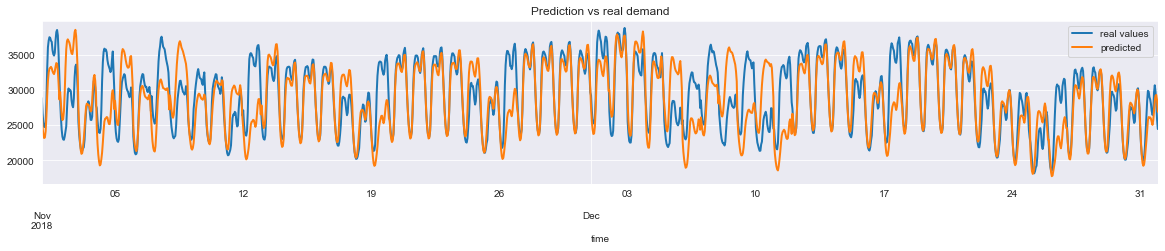

In [12]:
# Plot dei risultati
fig, ax = plt.subplots(figsize=(20, 3))
data_test['total load actual'].plot(linewidth=2, ax=ax)
predictions['predicted_mean'].plot(linewidth=2, ax=ax)
ax.set_title('Prediction vs real demand')
plt.legend(["real values", "predicted"])

I risultati sono molto simili a quelli ottenuti con l'AR(24), che per ora risulta essere il migliore in termini di pesantezza computazionale e numero di parametri.

---
## 2.2 Analisi dei residui

In [13]:
predictions

,predicted_mean,lower total load actual,upper total load actual
2018-11-01 00:00:00,26255.256919,24812.600837,27697.913001
2018-11-01 01:00:00,24691.075089,22224.651183,27157.498995
2018-11-01 02:00:00,23684.638797,20444.784472,26924.493122
2018-11-01 03:00:00,23179.649843,19318.475041,27040.824644
2018-11-01 04:00:00,23251.358228,18873.063291,27629.653165
...,...,...,...
2018-12-31 19:00:00,28418.096821,21810.315269,35025.878374
2018-12-31 20:00:00,29165.612463,22523.299610,35807.925317
2018-12-31 21:00:00,29289.632839,22608.482354,35970.783323
2018-12-31 22:00:00,28516.526106,21803.332309,35229.719903


Identifichiamo i residui e aggiungiamoli al dataframe contenente le previsioni

In [14]:
residuals = []
for ind in predictions["predicted_mean"].index:
    predicted_value = predictions['predicted_mean'][ind]
    real_value = data['total load actual'][data["time"] == ind].item()  # quì bisogna specificare la colonna time perché non è stata impostata come index date le necessità dei modelli
    residuals.append(predicted_value - real_value)

print(residuals[:10])

[-2574.743081100911, -1954.9249107394862, -1548.3612028369243, -1569.3501571996785, -1499.6417720043828, -1340.6596274727272, -1908.761079034557, -3767.3961834661022, -4753.06127519445, -4513.2862573589155]


In [15]:
# Aggiunta colonna al dataframe con le previsioni
predictions["residuals"] = residuals
predictions

,predicted_mean,lower total load actual,upper total load actual,residuals
2018-11-01 00:00:00,26255.256919,24812.600837,27697.913001,-2574.743081
2018-11-01 01:00:00,24691.075089,22224.651183,27157.498995,-1954.924911
2018-11-01 02:00:00,23684.638797,20444.784472,26924.493122,-1548.361203
2018-11-01 03:00:00,23179.649843,19318.475041,27040.824644,-1569.350157
2018-11-01 04:00:00,23251.358228,18873.063291,27629.653165,-1499.641772
...,...,...,...,...
2018-12-31 19:00:00,28418.096821,21810.315269,35025.878374,-2234.903179
2018-12-31 20:00:00,29165.612463,22523.299610,35807.925317,-569.387537
2018-12-31 21:00:00,29289.632839,22608.482354,35970.783323,1218.632839
2018-12-31 22:00:00,28516.526106,21803.332309,35229.719903,2715.526106


#### 2.2.1 Distribuzione dei residui

Text(0.5, 1.0, 'Residual distribution')

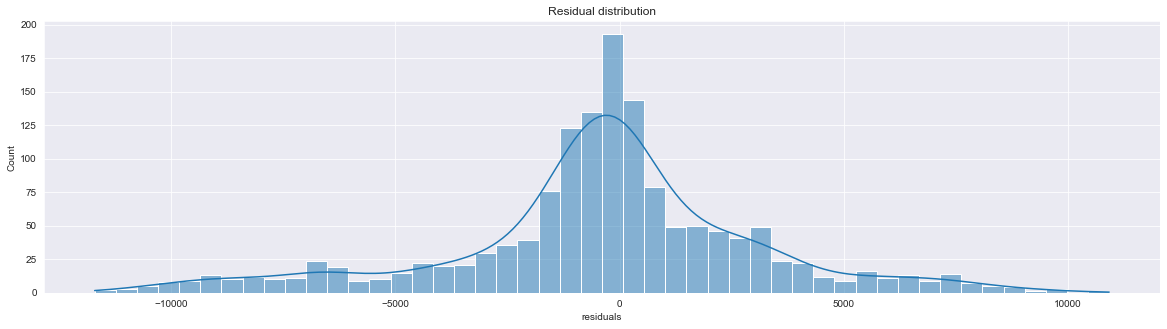

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))
sn.histplot(data=predictions, x="residuals", kde=True)
plt.title("Residual distribution")

I residui si distribuiscono come una normale

#### 2.2.2 Test per eteroschedasticità

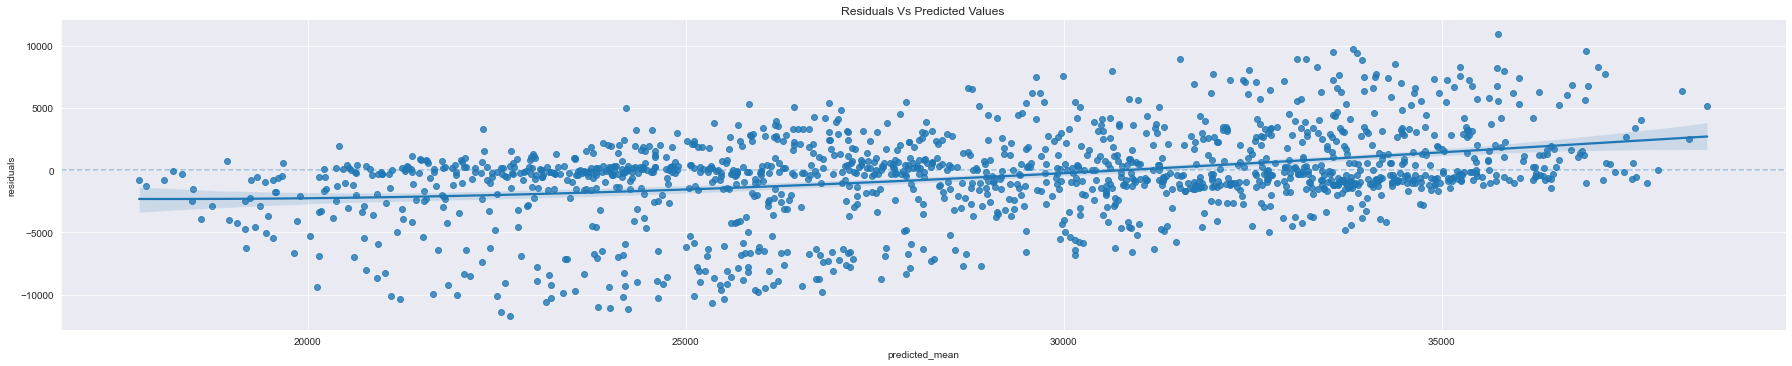

In [17]:
g = sn.lmplot(data=predictions, x="predicted_mean", y="residuals", height=5, aspect=5, order=3)

g.axes[0][0].axhline(y=0, ls = "--", alpha=0.4)

plt.title("Residuals Vs Predicted Values")
plt.show()

L'andamento non è molto lineare. È bene anche quì fare un test per accertarsi dell'entità dell' eteroschedasticità(varianza non costante nei termini di errore)

In [18]:
def test_model(col):
    final_array = []
    for value in col:
        a = [1, value]
        final_array.append(a)
    return np.array(final_array)

model = test_model(data_test["total load actual"])  # array dei valori reali di Y

In [19]:
# Breusch-Pagan Lagrange Multiplier test for heteroscedasticity
# ==============================================================================
""" It tests the hypothesis that the residual variance does not depend on the variables in x in the form """

bp_test = het_breuschpagan(predictions["residuals"], model)

print(f"LM-test p_value: {bp_test[1]}")

LM-test p_value: 8.44880961913291e-10


Il P-value è molto piccolo quindi confermiamo la presenza di eteroschedasticità.
Per risolvere questo problema si potrebbe agire sulla Y scalandola tramite una funzione concava in modo da ridurre il peso dei valori più elevati, e poi addestrare nuovamente il modello.

---
### 2.3 ARMA con Y scalata

In [20]:
# Backtest with prediction intervals
# ==============================================================================
mae, predictions = backtesting_sarimax(
                                       y=np.sqrt(data["total load actual"]),
                                       # exog=data[col_exog],
                                       order=(24, 0, 3),
                                       seasonal_order=(0, 0, 0, 0),
                                       initial_train_size=len(data.loc[:end_validation[0]]),
                                       fixed_train_size=False,
                                       steps=24,
                                       metric='mean_absolute_error',
                                       alpha=0.05,
                                       refit=False,
                                       verbose=True,
                                       fit_kwargs={'maxiter': 250, 'disp': 0},
)

# Test error
# ==============================================================================
mape = mean_absolute_percentage_error(
                y_true = np.sqrt(data_test['total load actual']),
                y_pred = predictions["predicted_mean"]
            )

print(f"Test error (mape): {mape}")
print(f"Test error (mae): {mae}")

Number of observations used for training: 33600
Number of observations used for backtesting: 1464
    Number of folds: 61
    Number of steps per fold: 24
Test error (mape): 0.041736508625576554
Test error (mae): 7.148417377824895


In [21]:
predictions

,predicted_mean,lower total load actual,upper total load actual
33600,162.069530,157.775930,166.363130
33601,157.191763,149.871922,164.511603
33602,153.943340,144.340948,163.545733
33603,152.347337,140.921205,163.773470
33604,152.536269,139.592056,165.480482
...,...,...,...
35059,167.961271,148.578610,187.343933
35060,170.172883,150.694425,189.651341
35061,170.506062,150.916607,190.095517
35062,168.176597,148.492202,187.860993


In [22]:
# Assegnazione indice al dataframe "data_test"
data_test.set_index(data_test["time"], inplace=True)
data_test.index = pd.to_datetime(data_test.index)

In [23]:
# Fix del dataframe con le previsioni
predictions = adjust_predictions(predictions, data)

In [24]:
residuals = []
for ind in predictions["predicted_mean"].index:
    predicted_value = predictions['predicted_mean'][ind]
    real_value = np.sqrt(data['total load actual'][data["time"] == ind].item())  # attenzione al sqrt
    residuals.append(predicted_value - real_value)

In [25]:
# Aggiunta colonna al dataframe con le previsioni
predictions["residuals"] = residuals
predictions

,predicted_mean,lower total load actual,upper total load actual,residuals
2018-11-01 00:00:00,162.069530,157.775930,166.363130,-7.724463
2018-11-01 01:00:00,157.191763,149.871922,164.511603,-6.044263
2018-11-01 02:00:00,153.943340,144.340948,163.545733,-4.905645
2018-11-01 03:00:00,152.347337,140.921205,163.773470,-4.970812
2018-11-01 04:00:00,152.536269,139.592056,165.480482,-4.788237
...,...,...,...,...
2018-12-31 19:00:00,167.961271,148.578610,187.343933,-7.118710
2018-12-31 20:00:00,170.172883,150.694425,189.651341,-2.265512
2018-12-31 21:00:00,170.506062,150.916607,190.095517,2.962038
2018-12-31 22:00:00,168.176597,148.492202,187.860993,7.549700


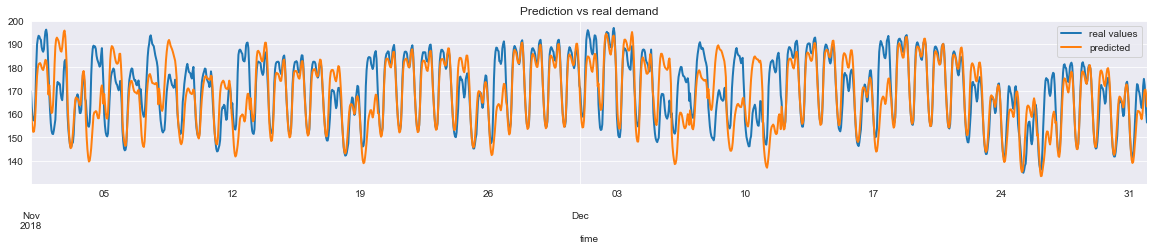

In [26]:
# Plot dei risultati
fig, ax = plt.subplots(figsize=(20, 3))
np.sqrt(data_test['total load actual']).plot(linewidth=2, ax=ax)
predictions['predicted_mean'].plot(linewidth=2, ax=ax)
ax.set_title('Prediction vs real demand')
plt.legend(["real values", "predicted"])

#### 2.3.1 Distribuzione dei residui

Text(0.5, 1.0, 'Residual distribution')

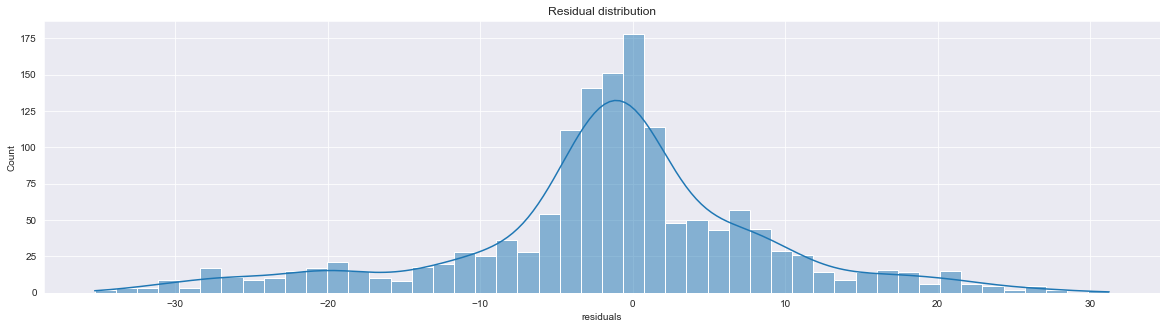

In [27]:
fig, ax = plt.subplots(figsize=(20, 5))
sn.histplot(data=predictions, x="residuals", kde=True)
plt.title("Residual distribution")

I residui si distribuiscono come una normale

#### 2.3.2 Test per eteroschedasticità

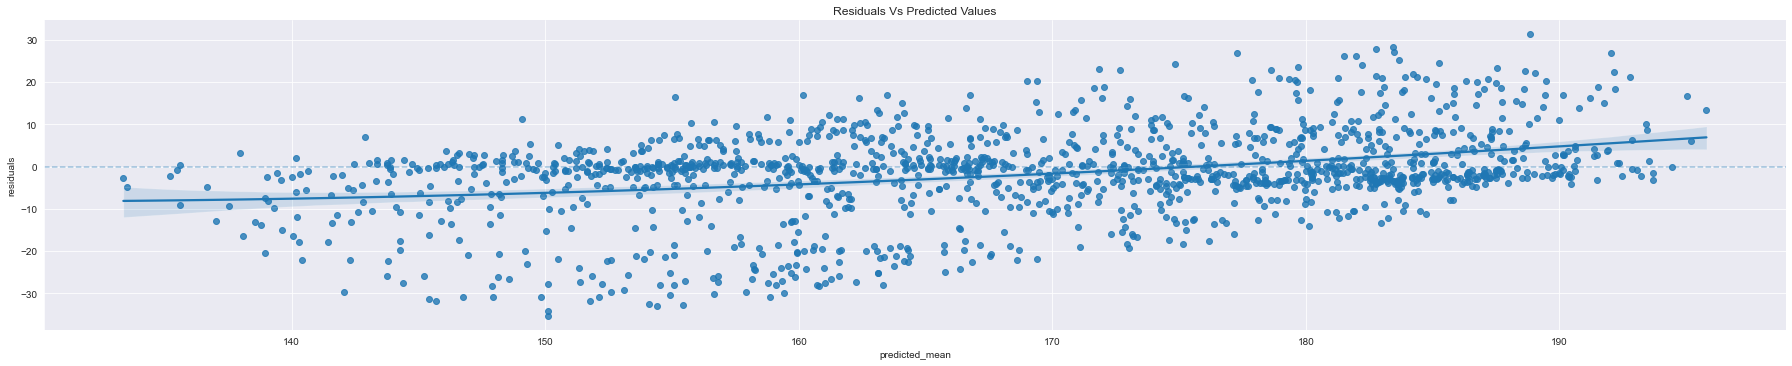

In [28]:
g = sn.lmplot(data=predictions, x="predicted_mean", y="residuals", height=5, aspect=5, order=3)

g.axes[0][0].axhline(y=0, ls = "--", alpha=0.4)

plt.title("Residuals Vs Predicted Values")
plt.show()

L'andamento non è molto lineare come prima. Anche se sembra comunque esserci eteroschedasticità vediamo come risponde al test.

In [29]:
model = test_model(data_test["total load actual"])  # array dei valori reali di Y

In [30]:
# Breusch-Pagan Lagrange Multiplier test for heteroscedasticity
# ==============================================================================
""" It tests the hypothesis that the residual variance does not depend on the variables in x in the form """

bp_test = het_breuschpagan(predictions["residuals"], model)

print(f"LM-test p_value: {bp_test[1]}")

LM-test p_value: 2.5095060365325294e-08


Il P-value è leggermente migliorato ma comunque rimane al di sotto di 0.05 e quindi siamo ancora in presenza di eteroschedasticità. Questo risultato ci porta a considerare i risultati dell'analisi come poco affidabili perché una delle ipotesi per la costruzione del modello non è rispettata, quindi tutte le misure che si basano quest'ultima sono falsate.

---
---
## 3 Aggiunta di variabili esogene
Andremo a considerare le stagionalità settimanali tramite le variabili dummy

In [31]:
# importazione dataset con dummies
df_dummies = pd.read_csv(py_path + "/Forecasting_Repository/data/interim/DF_SeasonalDummies.csv", index_col="time")
df_dummies.index = pd.to_datetime(df_dummies.index)
df_dummies.drop(columns="Unnamed: 0", inplace=True)
df_dummies

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 04:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,...,0,0,0,0,0,0,0,0,0,1
2018-12-31 20:00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,...,0,0,0,0,0,0,0,0,0,1
2018-12-31 21:00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,...,0,0,0,0,0,0,0,0,0,1


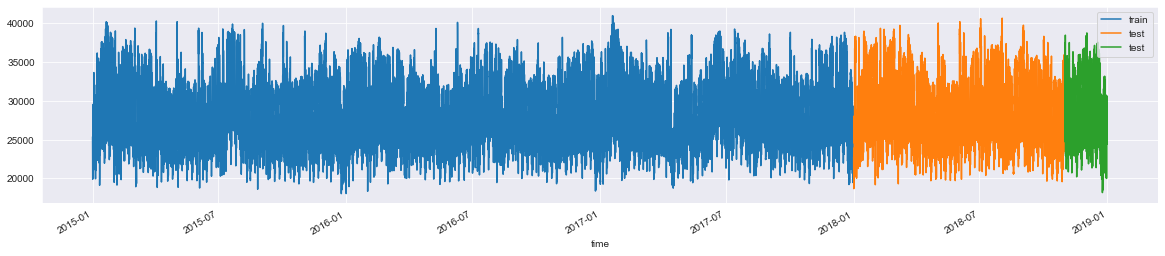

In [32]:
# Split data into train-val-test
# ==============================================================================
end_train = "2017-12-31 23:00:00"
start_validation = "2018-01-01 00:00:00"
end_validation = "2018-10-31 23:00:00"
start_test = "2018-11-01 00:00:00"

df_dummies_train = df_dummies.loc[: end_train, :]  # tre anni
df_dummies_validation = df_dummies.loc[start_validation: end_validation, :]  # dieci mesi
df_dummies_test = df_dummies.loc[start_test:, :]  # due mesi

fig, ax = plt.subplots(figsize=(20, 4))
df_dummies_train['total load actual'].plot(ax=ax, label='train')
df_dummies_validation['total load actual'].plot(ax=ax, label='test')
df_dummies_test['total load actual'].plot(ax=ax, label='test')
ax.legend()

In [33]:
# Selezione variabili dummy
dummies_cols = [i for i in df_dummies.iloc[:, [28, 53, 54, 55, 56, 57, 58, 59]]]  # Variabili relative al meteo
weather_cols = [i for i in df_dummies.iloc[:, 20:27]]  # Variabili dummy relative al giorno della settimana e Holidays
exog = weather_cols + dummies_cols

In [34]:
df_dummies[exog]

,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,Holidays,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6
time,,,,,,,,,,,,,,,
2015-01-01 00:00:00,1.000000e-07,0.451,0.0,0.0,0.0,2.781,0.0868,1,0,0,0,1,0,0,0
2015-01-01 01:00:00,2.000000e-07,0.234,0.0,0.0,0.0,2.781,0.1135,1,0,0,0,1,0,0,0
2015-01-01 02:00:00,2.000000e-07,0.129,0.0,0.0,0.0,2.781,0.0127,1,0,0,0,1,0,0,0
2015-01-01 03:00:00,2.000000e-07,0.008,0.0,0.0,0.0,0.278,0.1154,1,0,0,0,1,0,0,0
2015-01-01 04:00:00,1.000000e-07,0.042,0.0,0.0,0.0,0.278,0.0984,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.000000e+00,6.908,0.0,0.0,0.0,0.000,0.0305,0,1,0,0,0,0,0,0
2018-12-31 20:00:00,0.000000e+00,6.164,0.0,0.0,0.0,0.000,0.0338,0,1,0,0,0,0,0,0
2018-12-31 21:00:00,0.000000e+00,5.575,0.0,0.0,0.0,0.000,0.0408,0,1,0,0,0,0,0,0


In [41]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor=make_pipeline(StandardScaler(), Ridge()),
    lags=24
)


# Regressor's hyperparameters
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(forecaster=forecaster,
                                      y=df_dummies.loc[:end_validation, 'total load actual'],
                                      exog=df_dummies[exog][:end_validation], # df_dummies.iloc[:, [28, 53, 54, 55, 56, 57, 58, 59]][:end_validation], <-- solo giorno della settimana + holidays
                                      param_grid=param_grid,
                                      steps=24,
                                      metric='mean_absolute_error',
                                      refit=False,
                                      initial_train_size=len(df_dummies[:end_train]),
                                      fixed_train_size=False,
                                      return_best=True,
                                      verbose=False)

# Backtest final model
# ==============================================================================
""" MAE metric """

mae, predictions = backtesting_forecaster(forecaster=forecaster,  # forecaster fatto dalla best grid
                                          y=df_dummies['total load actual'],
                                          exog=df_dummies[exog],   # df_dummies.iloc[:, [28, 53, 54, 55, 56, 57, 58, 59]],  <-- solo giorno della settimana + holidays
                                          initial_train_size=len(df_dummies[:end_validation]),
                                          fixed_train_size=False,
                                          steps=24,
                                          metric='mean_absolute_error',
                                          refit=True,
                                          verbose=False
                                          )

# Test error
# ==============================================================================
mape = mean_absolute_percentage_error(
                y_true = df_dummies_test['total load actual'],
                y_pred = predictions
            )

print("FINAL METRICS:\n")
print(f"Test error (mape): {mape}\nTest error (mae): {mae}")

Number of models compared: 10


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:40<00:00, 40.65s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'ridge__alpha': 0.001}
  Backtesting metric: 2272.684261881512

Forecaster will be fit 61 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

FINAL METRICS:

Test error (mape): 0.07814235761397637
Test error (mae): 2281.9884911595277


##### Abbiamo migliorato un po' aggiungendo la variabile dummy del giorno della settimana.
Siamo passati da Backtest error: 2421 del primo *ARMA(24, 0, 3) no EXOG*
A un Backtest error: 2208 di un *AR EXOG stagionali*

Per ora i modelli semplici si stanno comportando meglio rispetto a quelli più complessi.

In [36]:
# Fix del dataframe con le previsioni
df_dummies_predictions_weekday = adjust_predictions(predictions, data)

In [37]:
df_dummies_test = df_dummies_test.set_index(data_test["time"])

In [38]:
df_dummies_predictions_weekday

,pred
2018-11-01 00:00:00,26219.010486
2018-11-01 01:00:00,24555.592336
2018-11-01 02:00:00,23430.921383
2018-11-01 03:00:00,22772.905682
2018-11-01 04:00:00,22746.857909
...,...
2018-12-31 19:00:00,31298.871449
2018-12-31 20:00:00,31985.499521
2018-12-31 21:00:00,32039.492594
2018-12-31 22:00:00,31171.391443


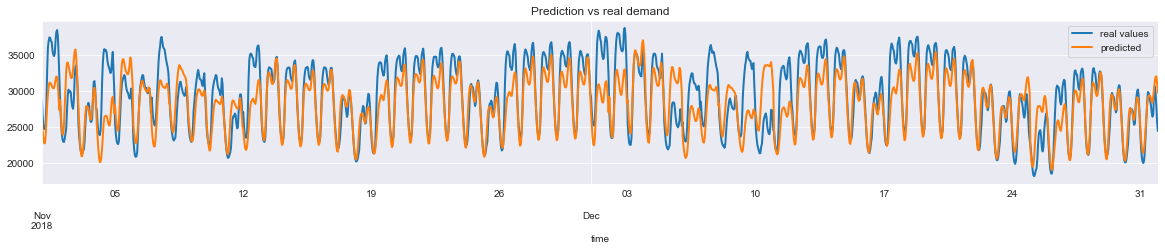

In [39]:
fig, ax = plt.subplots(figsize=(20, 3))
df_dummies_test['total load actual'].plot(linewidth=2, ax=ax)
df_dummies_predictions_weekday['pred'].plot(linewidth=2, ax=ax)
ax.set_title('Prediction vs real demand')
plt.legend(["real values", "predicted"])

La caratteristica comune a questi modelli, visibile anche a livello grafico, è che fanno fatica a prevedere le creste degli andamenti stagionali. I valori minimi vengono predetti male raramente a differenza dei valori massimi. Questo problema si accentua quando abbiamo dei picchi improvvisi nella distribuzione.
Probabilmente si possono ottenere risultati migliori andando a sfruttare modelli non lineari.

---
---
## 3. Test VARMAX

In [117]:
import statsmodels.api as sm

mod = sm.tsa.VARMAX(data[:len(data_validation) + len(data_train)][["total load actual", "temperature"]], order=(24, 0))  # training sul dataset che comprende sia il training-set che il validation-set
res = mod.fit(maxiter=100, disp=False)
print(res.summary())

                                    Statespace Model Results                                    
Dep. Variable:     ['total load actual', 'temperature']   No. Observations:                34320
Model:                                          VAR(24)   Log Likelihood             -379002.912
                                            + intercept   AIC                         758207.825
Date:                                  Fri, 02 Sep 2022   BIC                         759060.617
Time:                                          16:01:17   HQIC                        758479.712
Sample:                                               0                                         
                                                - 34320                                         
Covariance Type:                                    opg                                         
Ljung-Box (L1) (Q):           457.91, 0.61   Jarque-Bera (JB):   2562480.88, 173366.67
Prob(Q):                        0.00, 0.

Ci ha messo 30 minuti
Già osservando i risultati notiamo come il modello non sia adatto. BIC e AIC troppo elevati ad esempio.

In [118]:
predictions = res.forecast(744)  # previsione dei futuri 31 giorni = lunghezza del test set
predictions

,total load actual,temperature
34320,27496.897188,4.362237
34321,25764.662573,4.118794
34322,24586.507856,4.220772
34323,23775.056555,3.923613
34324,23756.285053,3.392327
...,...,...
35059,28744.304610,11.274643
35060,28731.054378,11.269060
35061,28710.584865,11.260262
35062,28686.538856,11.248442


In [128]:
predictions = adjust_predictions(predictions, data)

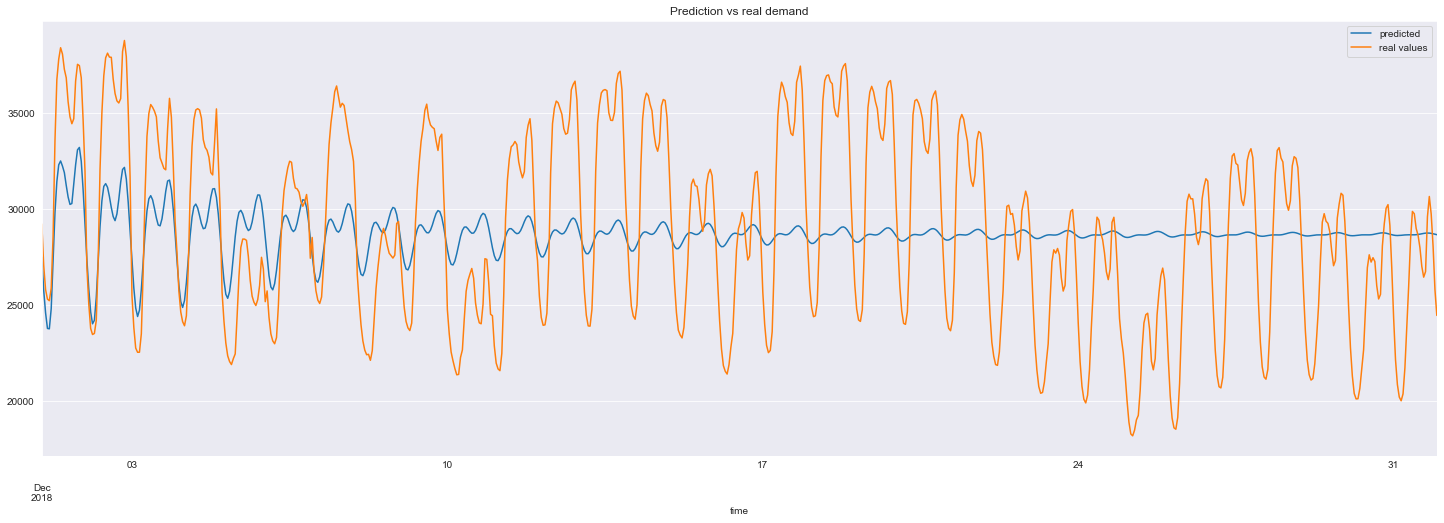

In [130]:
fig, ax = plt.subplots(figsize=(25, 8))
predictions["total load actual"].plot()  # valori predetti per l' ultimo mese prima del validation
data_test["total load actual"].plot()  # valori reali per l' ultimo mese prima del validation
ax.set_title('Prediction vs real demand')
plt.legend(["predicted", "real values"])

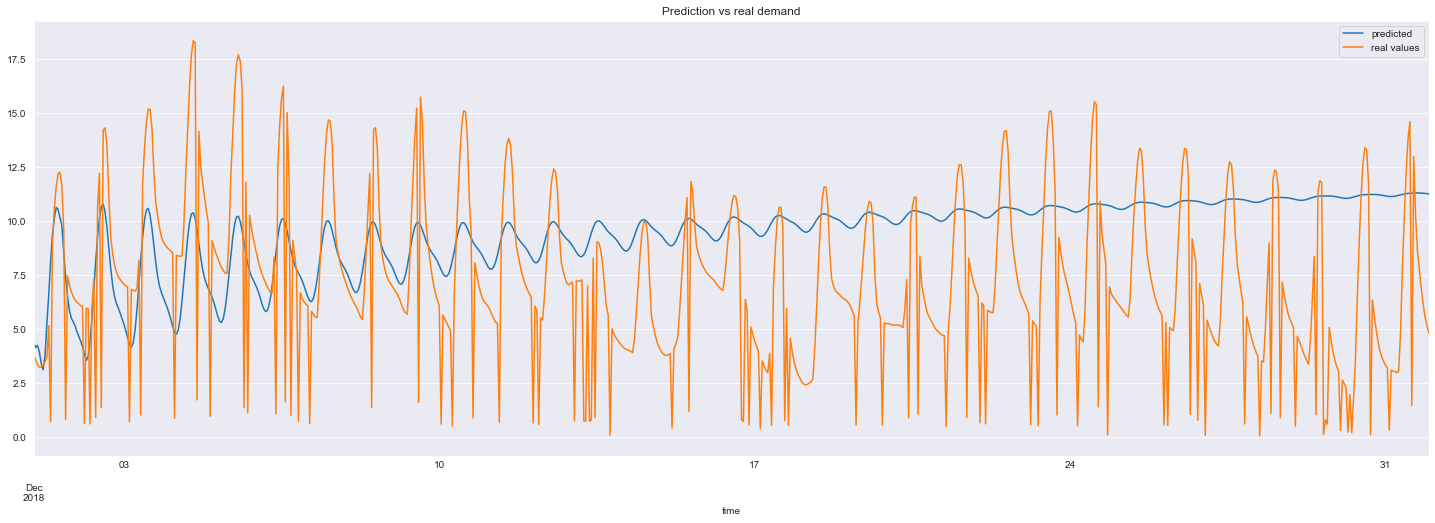

In [131]:
fig, ax = plt.subplots(figsize=(25, 8))
predictions["temperature"].plot()
data_test["temperature"].plot()
ax.set_title('Prediction vs real demand')
plt.legend(["predicted", "real values"])

I risultati sono pessimi come mostrato dai due grafici.

## SARIMAX


In [ ]:
# Backtest with prediction intervals
# ==============================================================================
mae, predictions = backtesting_sarimax(
                                       y=data["total load actual"],
                                       # exog=data[col_exog],
                                       order=(24, 0, 3),
                                       seasonal_order=(2, 0, 0, 1461),
                                       initial_train_size=len(data.loc[:end_validation[0]]),
                                       fixed_train_size=False,
                                       steps=24,
                                       metric='mean_absolute_error',
                                       alpha=0.05,
                                       refit=False,
                                       verbose=True,
                                       fit_kwargs={'maxiter': 250, 'disp': 0},
)


# Test error
# ==============================================================================
mape = mean_absolute_percentage_error(
                y_true = data_test['total load actual'],
                y_pred = predictions["predicted_mean"]
            )

print(f"Test error (mape): {mape}")
print(f"Test error (mae): {mae}")

Number of observations used for training: 20000
Number of observations used for backtesting: 15064
    Number of folds: 628
    Number of steps per fold: 24
    Last fold only includes 16 observations.
